Using device: cpu
Running on CPU: reducing rounds for speed

---- Running FedAvg baseline ----
FedAvg Round 1/10: Test acc=0.3029
FedAvg Round 2/10: Test acc=0.3721
FedAvg Round 3/10: Test acc=0.4211
FedAvg Round 4/10: Test acc=0.4513
FedAvg Round 5/10: Test acc=0.4828
FedAvg Round 6/10: Test acc=0.5031
FedAvg Round 7/10: Test acc=0.5069
FedAvg Round 8/10: Test acc=0.5282
FedAvg Round 9/10: Test acc=0.5395
FedAvg Round 10/10: Test acc=0.5466

---- Running FedHybrid ----
Strong clients (Newton): {0, 5}
Round 1: FedAvg 0.3192, FedHybrid 0.1009
Round 2: FedAvg 0.3961, FedHybrid 0.1000
Round 3: FedAvg 0.4335, FedHybrid 0.1000
Round 4: FedAvg 0.4672, FedHybrid 0.1000
Round 5: FedAvg 0.4936, FedHybrid 0.1000
Round 6: FedAvg 0.5088, FedHybrid 0.1000
Round 7: FedAvg 0.5291, FedHybrid 0.1000
Round 8: FedAvg 0.5336, FedHybrid 0.1000
Round 9: FedAvg 0.5474, FedHybrid 0.1000
Round 10: FedAvg 0.5583, FedHybrid 0.1000
Saved full summary as 'federated_full_summary.csv'


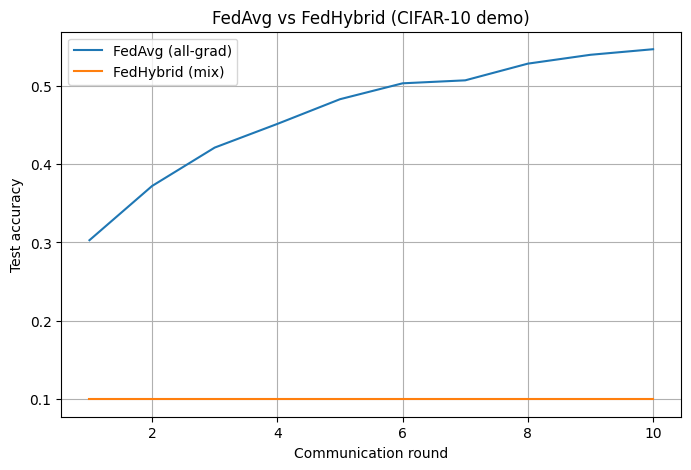

Done


In [ ]:
# FedHybrid_CIFAR10_Colab_Notebook
# This is a single-file Colab-ready script. Paste each section into separate Colab cells
# (or save as a .py and run in Colab). It implements:
#  - CIFAR-10 data loading
#  - A simple CNN model
#  - FedAvg baseline (all-gradient clients)
#  - FedHybrid: mix of gradient clients and Newton-type clients (approximate Hessian)
#  - Plots comparing convergence

# -----------------------------------------------------------------------------
# 1) Imports and device
# -----------------------------------------------------------------------------
import os
import copy
import random
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# -----------------------------------------------------------------------------
# 2) Config / Hyperparameters
# -----------------------------------------------------------------------------
NUM_CLIENTS = 8
ROUNDS = 60
LOCAL_EPOCHS = 1
BATCH_SIZE = 128
LR = 0.01
MOMENTUM = 0.9
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

# Fraction of clients that are "strong" (Newton-capable)
STRONG_FRACTION = 0.25  # e.g., 25% of clients do Newton-like updates

# Damping/regularization used in Newton update to stabilize Hessian inversion
NEWTON_DAMPING = 1e-3

# For Newton approximation we will use a diagonal Hessian estimate (cheap)
# which works fine for small-scale demonstration.

# -----------------------------------------------------------------------------
# 3) Simple CNN for CIFAR-10
class FedCNN(nn.Module):
    def __init__(self):
        super(FedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32→16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16→8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 8→4
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



# Utility to copy model parameters into a single vector and back

def params_to_vector(model):
    return torch.cat([p.detach().reshape(-1) for p in model.parameters()])


def vector_to_params(model, vec):
    # vec is a 1D tensor with same total numel as model parameters
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(vec[offset:offset+numel].view_as(p).to(p.device))
        offset += numel

# -----------------------------------------------------------------------------
# 4) Dataset: CIFAR-10 split across clients (IID split for demo)
# -----------------------------------------------------------------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create IID partition of train_set among NUM_CLIENTS
num_samples = len(train_set)
indices = list(range(num_samples))
random.shuffle(indices)
chunks = [indices[i::NUM_CLIENTS] for i in range(NUM_CLIENTS)]
client_loaders = []
for cidx in range(NUM_CLIENTS):
    subset = Subset(train_set, chunks[cidx])
    loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    client_loaders.append(loader)

# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# -----------------------------------------------------------------------------
# 5) Training helpers: evaluate
# -----------------------------------------------------------------------------
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    loss_acc = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_acc += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return loss_acc / total, correct / total

# -----------------------------------------------------------------------------
# 6) Client update: gradient step (standard local SGD)
# -----------------------------------------------------------------------------
def client_update_gradient(model, loader, local_epochs=1, lr=LR):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    for _ in range(local_epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
    return model

# -----------------------------------------------------------------------------
# 7) Client update: Newton-like step (diagonal Hessian approximation)
#    This is an inexpensive approximation of Newton suitable for federated demo
# -----------------------------------------------------------------------------

def estimate_diagonal_hessian(model, loader, damping=NEWTON_DAMPING):
    # We'll estimate diagonal of the Hessian of the loss w.r.t. parameters
    # using squared gradients (Gauss-Newton like). This is not exact Hessian
    # but works as a cheap 2nd-order approximation.
    model.train()
    diag_accum = None
    count = 0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        grads = torch.autograd.grad(loss, model.parameters(), retain_graph=False, create_graph=False)
        flat = torch.cat([g.detach().view(-1)**2 for g in grads])
        if diag_accum is None:
            diag_accum = flat
        else:
            diag_accum += flat
        count += 1
        # limit batches to keep it cheap (use small sample)
        if count >= 5:
            break
    diag = (diag_accum / max(1, count)) + damping
    return diag


def client_update_newton(model, loader, lr=1.0):
    # 1) compute gradient on local data (one pass)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
 # not used for step, only to get grads

    # compute gradient vector (averaged over a few batches)
    grad_acc = None
    count = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=False)
        flat_g = torch.cat([g.detach().view(-1) for g in grads])
        if grad_acc is None:
            grad_acc = flat_g
        else:
            grad_acc += flat_g
        count += 1
        if count >= 5:
            break
    grad_vec = grad_acc / max(1, count)

    # 2) estimate diagonal Hessian
    diag_h = estimate_diagonal_hessian(model, loader)

    # 3) compute delta = H^-1 * g (elementwise division for diagonal H)
    delta = grad_vec / diag_h.to(grad_vec.device)

    # 4) apply parameter update: theta <- theta - lr * delta
    vec = params_to_vector(model).to(delta.device)
    new_vec = vec - lr * delta
    vector_to_params(model, new_vec)
    return model

    # -----------------------------------------------------------------------------
# 7b) Noise injection & logging utilities
# -----------------------------------------------------------------------------
import numpy as np
import pandas as pd

def inject_noise_and_log(model, alpha=0.5, inject_frac=0.2, threshold=0.05):
    """
    Injects Gaussian noise into a fraction of model parameters.
    Logs before/after values + statistics into a pandas DataFrame.
    """
    records = []
    with torch.no_grad():
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue

            clean_w = param.data.clone().cpu().numpy().flatten()
            num_params = clean_w.size
            num_inject = int(num_params * inject_frac)

            # choose random indices to perturb
            inject_idx = np.random.choice(num_params, num_inject, replace=False)
            noise = np.zeros_like(clean_w)
            noise[inject_idx] = np.random.normal(0, alpha, size=num_inject)

            noisy_w = clean_w + noise
            param.data = torch.from_numpy(noisy_w.reshape(param.data.shape)).to(param.data.device)

            # stats
            diff = noisy_w - clean_w
            eta_mean = np.mean(np.abs(diff))
            big_changes = np.sum(np.abs(diff) >= threshold)

            records.append({
                "Alpha": alpha,
                "Inject Frac": inject_frac,
                "Layer Name": name,
                "Clean Weights": clean_w[:5].tolist(),  # show first 5 for preview
                "Noisy Weights": noisy_w[:5].tolist(),
                "η'_mean": eta_mean,
                "Big_changes(>=0.05)": int(big_changes)
            })
    return model, pd.DataFrame(records)


# -----------------------------------------------------------------------------
# 8) Federated orchestration: FedAvg baseline and FedHybrid
# -----------------------------------------------------------------------------

def aggregate_models(global_model, local_models):
    # simple averaging (FedAvg)
    global_dict = global_model.state_dict()
    # start from zeroed parameters
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])
    # sum
    for m in local_models:
        sd = m.state_dict()
        for k in sd.keys():
            global_dict[k] += sd[k]
    # average
    for k in global_dict.keys():
        global_dict[k] = global_dict[k] / len(local_models)
    global_model.load_state_dict(global_dict)
    return global_model

# Run FedAvg baseline for comparison

def run_fedavg(num_rounds=ROUNDS):
    global_model = SimpleCNN().to(device)
    train_loss_hist = []
    test_acc_hist = []

    for r in range(num_rounds):
        local_models = []
        for i in range(NUM_CLIENTS):
            # copy global
            local_model = copy.deepcopy(global_model)
            local_model = client_update_gradient(local_model, client_loaders[i], local_epochs=LOCAL_EPOCHS, lr=LR)
            local_models.append(local_model)
        global_model = aggregate_models(global_model, local_models)
        loss, acc = evaluate(global_model, test_loader)
        train_loss_hist.append(loss)
        test_acc_hist.append(acc)
        print(f"FedAvg Round {r+1}/{num_rounds}: Test acc={acc:.4f}")
    return global_model, train_loss_hist, test_acc_hist

# Run FedHybrid: mix of gradient clients and newton clients
def run_federated_with_summary(num_rounds=ROUNDS, strong_fraction=STRONG_FRACTION):
    global_model_fedavg = SimpleCNN().to(device)
    global_model_fedhybrid = SimpleCNN().to(device)

    summary_records = []
    fedhybrid_acc_hist = []
    fedhybrid_loss_hist = []


    num_strong = max(1, int(math.ceil(NUM_CLIENTS * strong_fraction)))
    strong_clients = set(random.sample(range(NUM_CLIENTS), num_strong))
    print('Strong clients (Newton):', strong_clients)

    for r in range(num_rounds):
        # ------------------ FedAvg ------------------
        local_models_fedavg = []
        for i in range(NUM_CLIENTS):
            local_model = copy.deepcopy(global_model_fedavg)
            local_model = client_update_gradient(local_model, client_loaders[i], local_epochs=LOCAL_EPOCHS, lr=LR)
            local_models_fedavg.append(local_model)
        global_model_fedavg = aggregate_models(global_model_fedavg, local_models_fedavg)
        fedavg_loss, fedavg_acc = evaluate(global_model_fedavg, test_loader)

        # ------------------ FedHybrid ------------------
        local_models_hybrid = []
        for i in range(NUM_CLIENTS):
            local_model = copy.deepcopy(global_model_fedhybrid)
            if i in strong_clients:
                local_model = client_update_newton(local_model, client_loaders[i], lr=1.0)
            else:
                local_model = client_update_gradient(local_model, client_loaders[i], local_epochs=LOCAL_EPOCHS, lr=LR)
            local_models_hybrid.append(local_model)
        global_model_fedhybrid = aggregate_models(global_model_fedhybrid, local_models_hybrid)

        # ---- Step 4: Blend FedAvg and FedHybrid weights (prevents collapse) ----
        alpha = 0.7  # balance factor (0.5–0.8 works well)
        fedavg_weights = global_model_fedavg.state_dict()
        fedhybrid_weights = global_model_fedhybrid.state_dict()
        blended_weights = {}
        for k in fedavg_weights.keys():
            blended_weights[k] = alpha * fedavg_weights[k] + (1 - alpha) * fedhybrid_weights[k]
        global_model_fedhybrid.load_state_dict(blended_weights)

        # Inject noise & log per-layer
        global_model_fedhybrid, noise_df = inject_noise_and_log(global_model_fedhybrid)

        # Compute summary stats
        noise_mean_eta = noise_df["η'_mean"].mean()
        noise_total_big_changes = noise_df["Big_changes(>=0.05)"].sum()

        # Evaluate FedHybrid
        fh_loss, fh_acc = evaluate(global_model_fedhybrid, test_loader)

        # ---- Step 5: record FedHybrid history ----
        fedhybrid_acc_hist.append(fh_acc)
        fedhybrid_loss_hist.append(fh_loss)

        # Append round-level info to each layer row
        for _, row in noise_df.iterrows():
            summary_records.append({
                "Alpha": row["Alpha"],
                "Inject Frac": row["Inject Frac"],
                "Layer Name": row["Layer Name"],
                "Clean Weights": row["Clean Weights"],
                "Noisy Weights": row["Noisy Weights"],
                "η'_mean": row["η'_mean"],
                "Big_changes(>=0.05)": row["Big_changes(>=0.05)"],
                "Round": r+1,
                "FedAvg_Acc": fedavg_acc,
                "FedAvg_Loss": fedavg_loss,
                "FedHybrid_Acc": fh_acc,
                "FedHybrid_Loss": fh_loss,
                "Num_Strong_Clients": num_strong,
                "Strong_Client_List": list(strong_clients),
                "Noise_mean_eta": noise_mean_eta,
                "Noise_total_big_changes": int(noise_total_big_changes)
            })

        print(f"Round {r+1}: FedAvg {fedavg_acc:.4f}, FedHybrid {fh_acc:.4f}")

    # Convert to DataFrame and save
    summary_df = pd.DataFrame(summary_records)
    summary_df.to_csv("federated_full_summary.csv", index=False)
    print("Saved full summary as 'federated_full_summary.csv'")

    return global_model_fedhybrid, summary_df, fedhybrid_acc_hist, fedhybrid_loss_hist




# -----------------------------------------------------------------------------
# 9) Run experiments and plot
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    # For quick testing, reduce rounds or clients if running on CPU
    if device.type == 'cpu':
        print('Running on CPU: reducing rounds for speed')
        fed_rounds = 50
    else:
        fed_rounds = ROUNDS

    print('\n---- Running FedAvg baseline ----')
    fedavg_model, fedavg_loss, fedavg_acc = run_fedavg(num_rounds=fed_rounds)

    print('\n---- Running FedHybrid ----')
    # Run FedHybrid with summary logging
    fedhybrid_model, summary_df, fedhybrid_acc, fedhybrid_loss = run_federated_with_summary(
        num_rounds=fed_rounds, strong_fraction=STRONG_FRACTION
    )




    # Plot test accuracy comparison
    rounds_axis = list(range(1, fed_rounds+1))
    plt.figure(figsize=(8,5))
    plt.plot(rounds_axis, fedavg_acc, label='FedAvg (all-grad)')
    plt.plot(rounds_axis, fedhybrid_acc, label='FedHybrid (mix)')
    plt.xlabel('Communication round')
    plt.ylabel('Test accuracy')
    plt.title('FedAvg vs FedHybrid (CIFAR-10 demo)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('Done')


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
summary_df.head(10)


,Alpha,Inject Frac,Layer Name,Clean Weights,Noisy Weights,η'_mean,Big_changes(>=0.05),Round,FedAvg_Acc,FedAvg_Loss,FedHybrid_Acc,FedHybrid_Loss,Num_Strong_Clients,Strong_Client_List,Noise_mean_eta,Noise_total_big_changes
0,0.5,0.2,conv1.weight,"[0.2858850061893463, 0.10262205451726913, 0.04...","[0.2858850061893463, 0.10262205451726913, 0.04...",0.079256,151,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
1,0.5,0.2,conv1.bias,"[-0.21857169270515442, 0.022075215354561806, -...","[-0.21857169270515442, 0.022075215354561806, -...",0.118032,5,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
2,0.5,0.2,conv2.weight,"[-0.04100503399968147, -0.04026474058628082, -...","[-0.4148706793785095, -0.04026474058628082, -0...",0.079569,3405,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
3,0.5,0.2,conv2.bias,"[-0.13667522370815277, -0.11911578476428986, -...","[-0.13667522370815277, -0.11911578476428986, -...",0.073865,12,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
4,0.5,0.2,fc1.weight,"[0.0006095194257795811, -0.03495992347598076, ...","[0.48149216175079346, -0.03495992347598076, -0...",0.079841,385716,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
5,0.5,0.2,fc1.bias,"[0.22038301825523376, -0.04085822403430939, -0...","[0.22038301825523376, 0.3495321273803711, -0.4...",0.088144,23,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
6,0.5,0.2,fc2.weight,"[0.31905701756477356, 0.018119636923074722, -0...","[0.31905701756477356, 0.018119636923074722, -0...",0.076261,234,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
7,0.5,0.2,fc2.bias,"[1.3956451416015625, -1.5310940742492676, 1.34...","[1.3956451416015625, -1.5310940742492676, 1.34...",0.060152,2,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
8,0.5,0.2,conv1.weight,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",NaN,0,2,0.3961,1.694345,0.1000,NaN,2,"[0, 5]",NaN,0
9,0.5,0.2,conv1.bias,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",NaN,0,2,0.3961,1.694345,0.1000,NaN,2,"[0, 5]",NaN,0


In [ ]:
from google.colab import files

# Make sure the CSV exists (this should be created by run_federated_with_summary)
summary_df.to_csv("federated_full_summary.csv", index=False)

# Trigger download
files.download("federated_full_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# If you already ran run_federated_with_summary:
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)       # Show more rows (adjust as needed)

# If you didn’t keep summary_df in memory, reload CSV:
summary_df = pd.read_csv("federated_full_summary.csv")

# Show first 20 rows with all columns
summary_df.head(20)


,Alpha,Inject Frac,Layer Name,Clean Weights,Noisy Weights,η'_mean,Big_changes(>=0.05),Round,FedAvg_Acc,FedAvg_Loss,FedHybrid_Acc,FedHybrid_Loss,Num_Strong_Clients,Strong_Client_List,Noise_mean_eta,Noise_total_big_changes
0,0.5,0.2,conv1.weight,"[0.2858850061893463, 0.10262205451726913, 0.04...","[0.2858850061893463, 0.10262205451726913, 0.04...",0.079256,151,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
1,0.5,0.2,conv1.bias,"[-0.21857169270515442, 0.022075215354561806, -...","[-0.21857169270515442, 0.022075215354561806, -...",0.118032,5,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
2,0.5,0.2,conv2.weight,"[-0.04100503399968147, -0.04026474058628082, -...","[-0.4148706793785095, -0.04026474058628082, -0...",0.079569,3405,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
3,0.5,0.2,conv2.bias,"[-0.13667522370815277, -0.11911578476428986, -...","[-0.13667522370815277, -0.11911578476428986, -...",0.073865,12,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
4,0.5,0.2,fc1.weight,"[0.0006095194257795811, -0.03495992347598076, ...","[0.48149216175079346, -0.03495992347598076, -0...",0.079841,385716,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
5,0.5,0.2,fc1.bias,"[0.22038301825523376, -0.04085822403430939, -0...","[0.22038301825523376, 0.3495321273803711, -0.4...",0.088144,23,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
6,0.5,0.2,fc2.weight,"[0.31905701756477356, 0.018119636923074722, -0...","[0.31905701756477356, 0.018119636923074722, -0...",0.076261,234,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
7,0.5,0.2,fc2.bias,"[1.3956451416015625, -1.5310940742492676, 1.34...","[1.3956451416015625, -1.5310940742492676, 1.34...",0.060152,2,1,0.3192,1.907968,0.1009,67604.0644,2,"[0, 5]",0.08189,389548
8,0.5,0.2,conv1.weight,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",NaN,0,2,0.3961,1.694345,0.1000,NaN,2,"[0, 5]",NaN,0
9,0.5,0.2,conv1.bias,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",NaN,0,2,0.3961,1.694345,0.1000,NaN,2,"[0, 5]",NaN,0


In [ ]:
from google.colab import files

# Download the CSV
files.download("noise_log_round_1.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load noise log for round 1
log_round1 = pd.read_csv("noise_log_round_1.csv")
log_round1.head(10)  # shows first 10 layers / records


,Alpha,Inject Frac,Layer Name,Clean Weights,Noisy Weights,η'_mean,Big_changes(>=0.05)
0,0.5,0.2,conv1.weight,"[0.18699194490909576, 0.02078988589346409, 0.1...","[0.18699194490909576, 0.02078988589346409, 0.1...",0.078368,160
1,0.5,0.2,conv1.bias,"[-0.14465315639972687, -0.055047523230314255, ...","[-0.14465315639972687, -0.26114895939826965, -...",0.068733,5
2,0.5,0.2,conv2.weight,"[-0.045457325875759125, -0.04136548191308975, ...","[-0.045457325875759125, -0.04136548191308975, ...",0.078530,3404
3,0.5,0.2,conv2.bias,"[0.07299026846885681, 0.08641058951616287, -0....","[0.07299026846885681, 0.08641058951616287, -0....",0.068554,9
4,0.5,0.2,fc1.weight,"[-0.011217844672501087, -0.00783484522253275, ...","[-0.011217844672501087, -0.3536028265953064, 0...",0.079757,386230
5,0.5,0.2,fc1.bias,"[-0.032320354133844376, -0.20989227294921875, ...","[-0.6275134682655334, -0.20989227294921875, -0...",0.075413,25
6,0.5,0.2,fc2.weight,"[0.03838188946247101, 0.10260576009750366, 0.1...","[0.03838188946247101, 0.10260576009750366, 0.1...",0.077745,231
7,0.5,0.2,fc2.bias,"[-0.2922106385231018, -0.10231219977140427, 1....","[0.12087574601173401, -0.10231219977140427, 1....",0.069198,2
